In [2]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from gaussian_mixture_anomaly_detection import GaussianMixtureInTimeAnomalyDetector
from gaussian_mixture_anomaly_detection import extract_anomaly_target, smoothed_sample_anomalies
import matplotlib.pyplot as plt
%matplotlib inline

простой пример: 10 двумерных временных рядов по 10 элементов в каждом,лежащие на 3x=2y со случайным нормальным смещением, а также 4 аномальные точки

In [3]:
T = 10
F = 40
N = 2

data = np.zeros((F, T, N))

for i in range(F):
    for t in range(T):
        data[i][t] = np.array([2,3]) * t + sps.norm.rvs(size=2,scale=0.5)
        
anomalies = [(0,5,0), (1,3,1), (1,4,1), (2,8,1), (3,2,0)]
for a in anomalies:
    data[a[0]][a[1]][a[2]] += 5

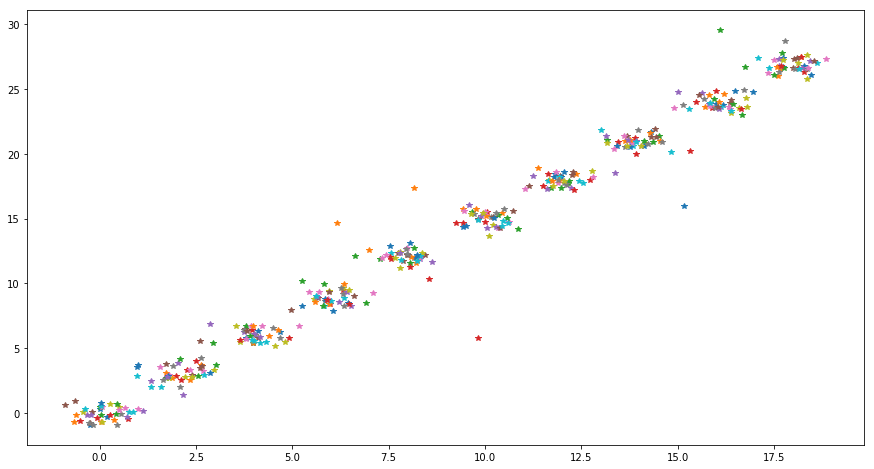

In [4]:
plt.figure(figsize=(15,8))
for i in range(F):
    plt.plot(data[i][:, 0], data[i][:, 1], '*')
# plt.grid()
plt.show()

In [5]:
detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=1)

In [6]:
scores = detector.fit(data)  # scores  - логарифмическое правдоподобие нормальности для каждого сэмпла

Start probabilities memorization
100%|██████████| 40/40 [00:00<00:00, 363.12it/s]


выявление аномальных сэмплов:

In [7]:
detector.find_anomalies(scores, log_likelihood_threshold=0)

([(-21.476557341260786, (3, 2)),
  (-17.880399641778762, (0, 5)),
  (-14.67835175838176, (1, 3)),
  (-13.76835952818965, (2, 8)),
  (-13.621045153393746, (1, 4)),
  (-1.8556867619075599, (3, 4)),
  (-1.7928119614578957, (33, 7)),
  (-0.80447758542896441, (15, 2)),
  (-0.72103091612008974, (14, 2)),
  (-0.3835320458448383, (4, 1)),
  (-0.25750078855978975, (26, 2)),
  (-0.16977878530667875, (37, 9)),
  (-0.12252289284350429, (14, 8)),
  (-0.043250919745312588, (39, 7))],
 0)

In [8]:
detector.find_anomalies(scores, anomaly_top=0.05)

([(-21.476557341260786, (3, 2)),
  (-17.880399641778762, (0, 5)),
  (-14.67835175838176, (1, 3)),
  (-13.76835952818965, (2, 8)),
  (-13.621045153393746, (1, 4)),
  (-1.8556867619075599, (3, 4)),
  (-1.7928119614578957, (33, 7)),
  (-0.80447758542896441, (15, 2)),
  (-0.72103091612008974, (14, 2)),
  (-0.3835320458448383, (4, 1)),
  (-0.25750078855978975, (26, 2)),
  (-0.16977878530667875, (37, 9)),
  (-0.12252289284350429, (14, 8)),
  (-0.043250919745312588, (39, 7)),
  (0.032220759798016647, (32, 4)),
  (0.13711624192828253, (19, 7)),
  (0.31652087788097955, (12, 3)),
  (0.33013898941689851, (36, 8)),
  (0.34785428515430367, (10, 8)),
  (0.42623296610067785, (35, 0)),
  (0.45862217957772733, (15, 0))],
 0.45862217957772733)

как видно аномалии попали в топ 5%

In [9]:
detector.find_anomalies(scores, anomaly_top=0.1, strategy='series')

([(-8.3499391378175645, 1),
  (-2.0068741665795762, 3),
  (4.6393764844315335, 0),
  (9.3526201566473404, 2),
  (18.810502399943449, 22)],
 18.810502399943449)

2 ряда с добавленными аномалиями попали в топ по сумме логорифимических правдоподобий

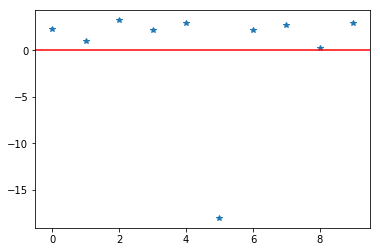

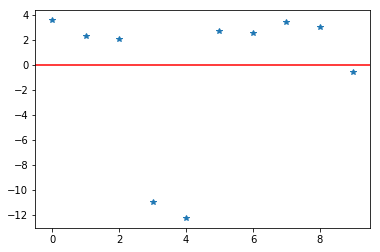

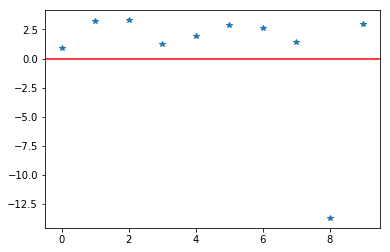

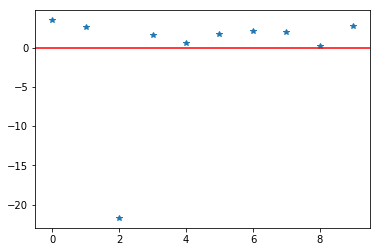

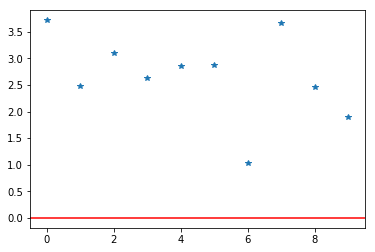

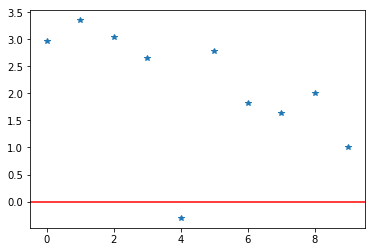

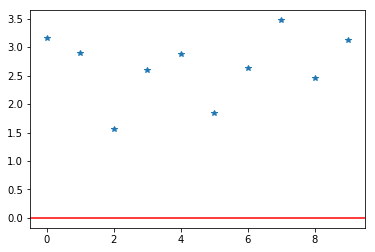

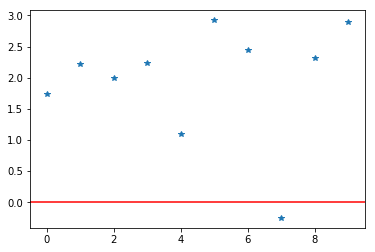

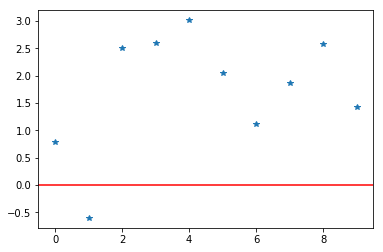

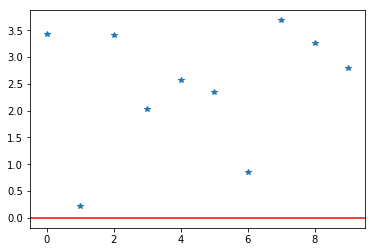

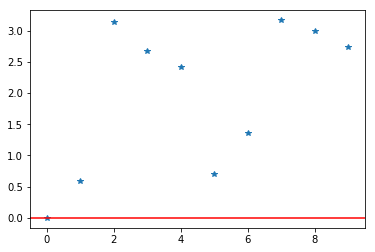

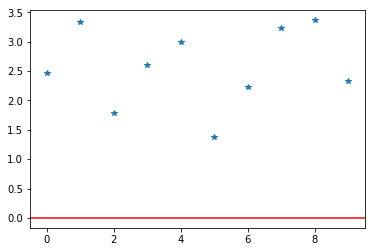

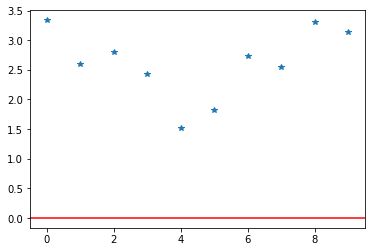

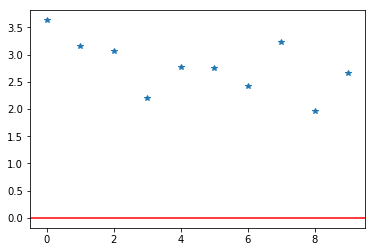

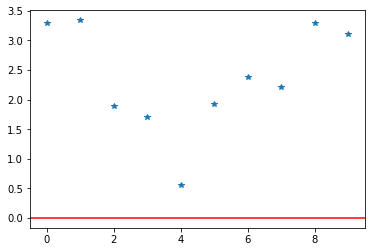

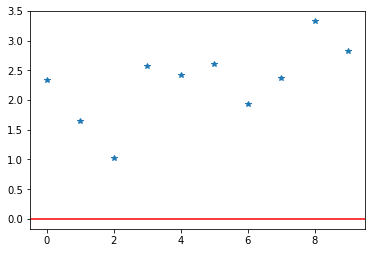

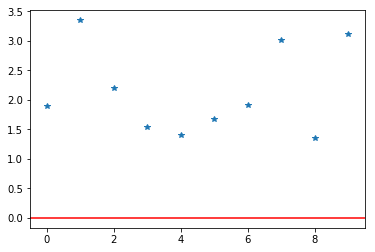

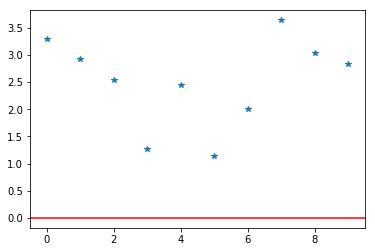

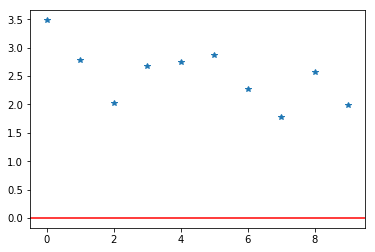

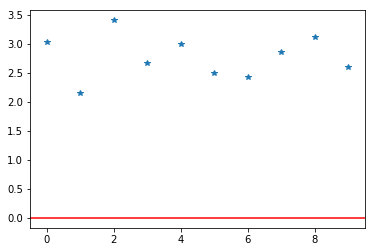

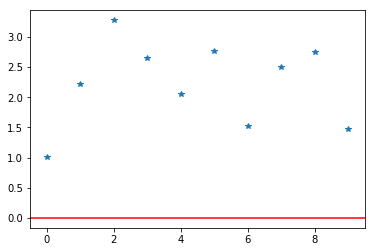

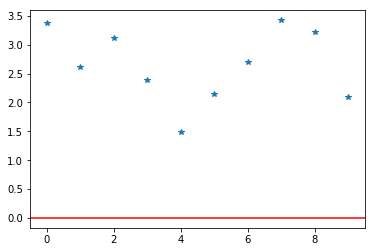

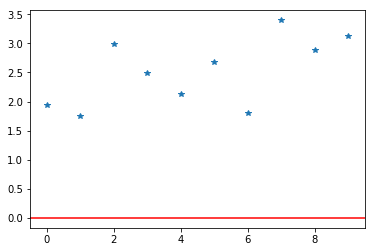

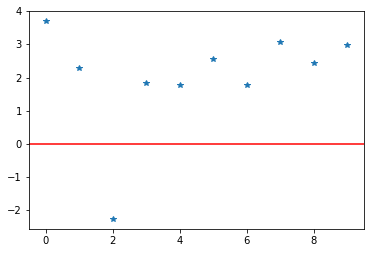

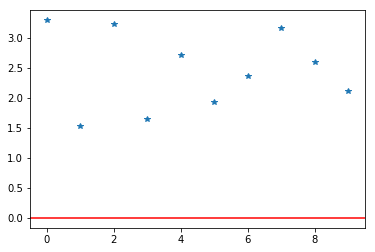

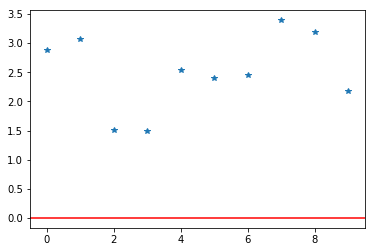

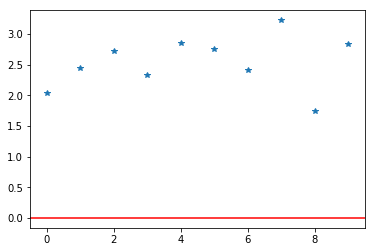

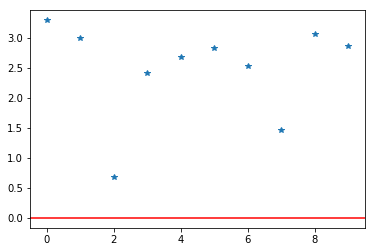

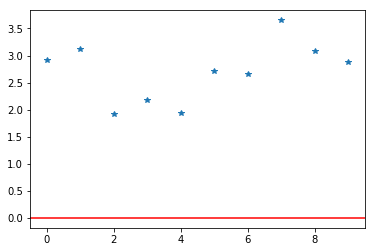

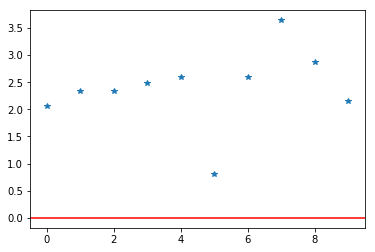

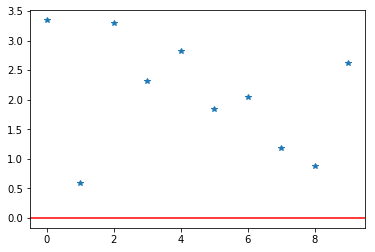

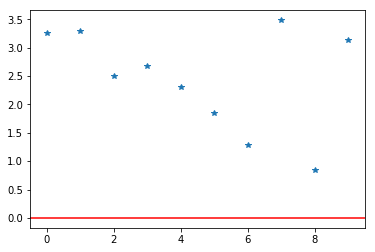

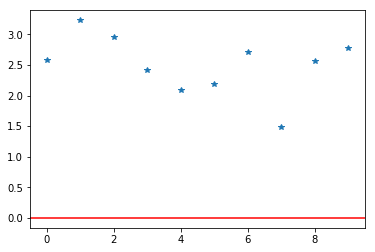

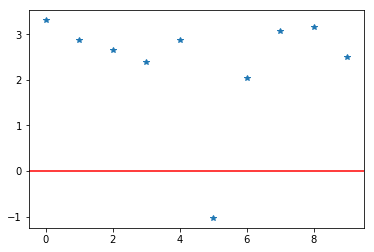

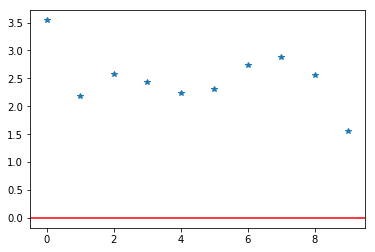

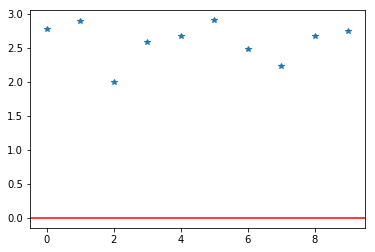

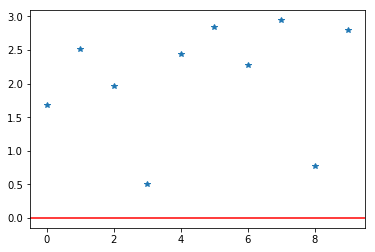

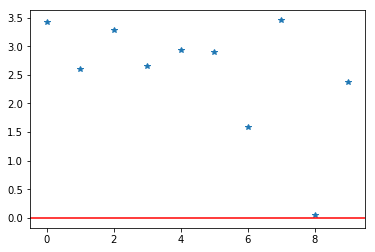

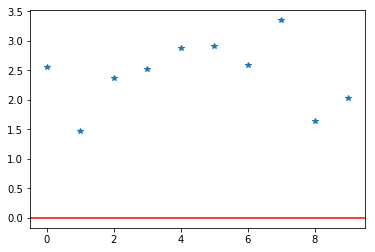

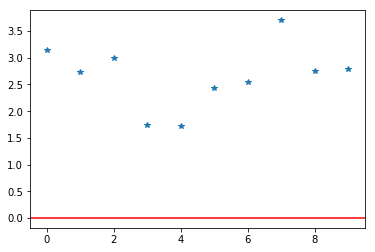

In [27]:
for f in range(F):
    plt.plot(range(T), scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [28]:
smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife=2)

/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


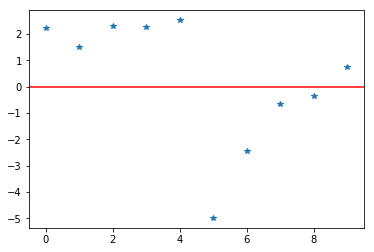

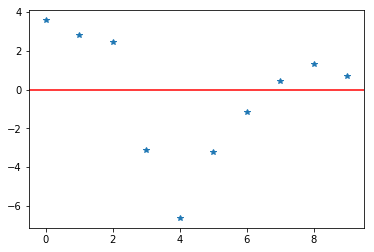

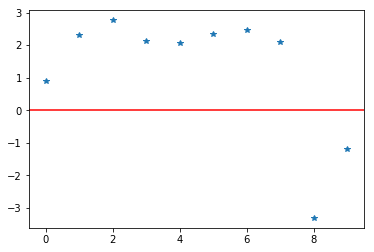

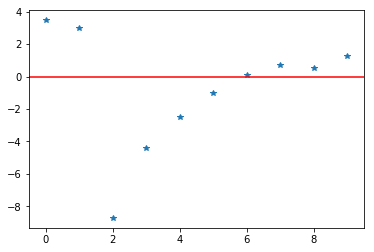

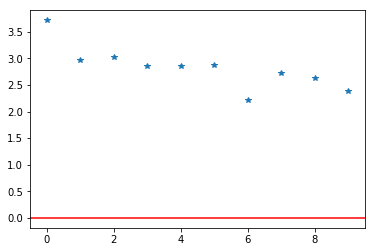

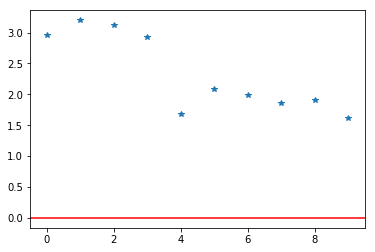

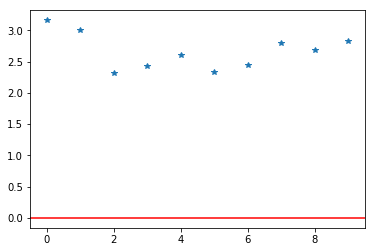

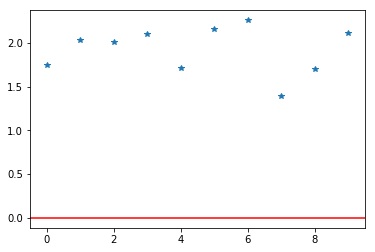

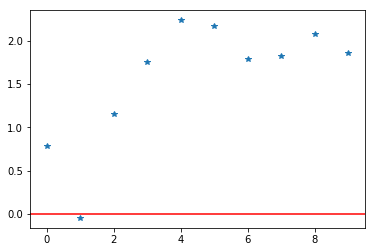

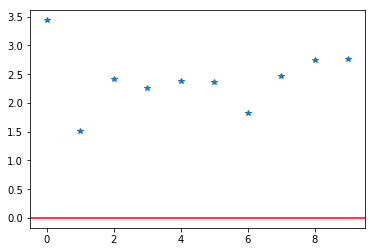

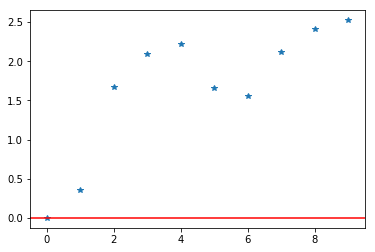

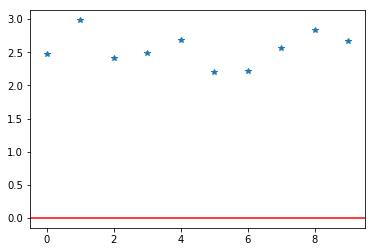

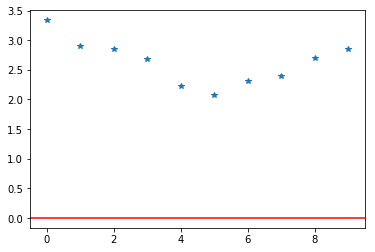

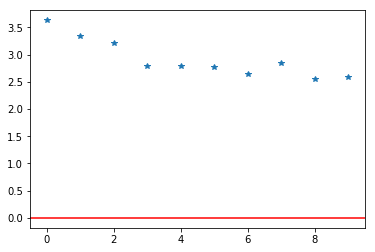

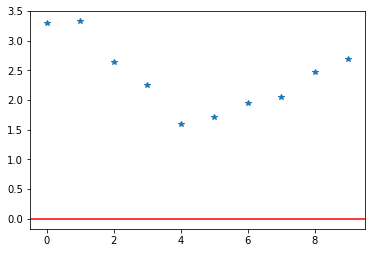

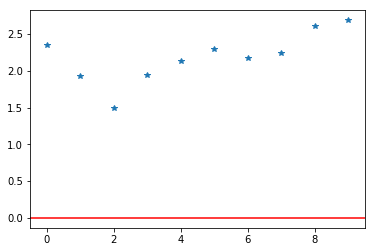

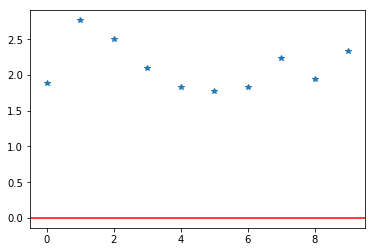

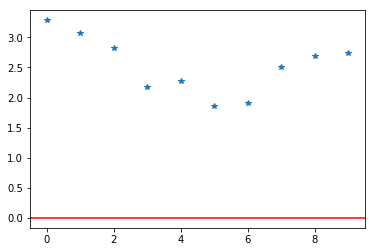

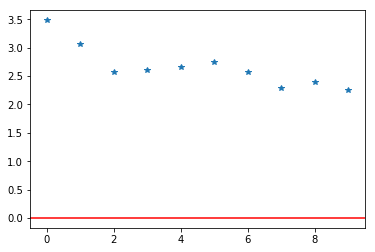

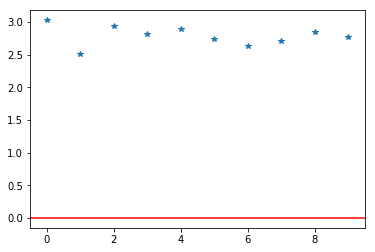

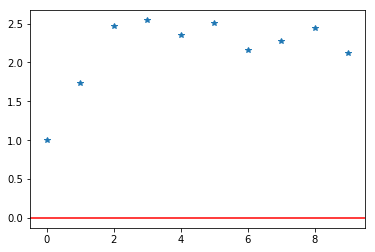

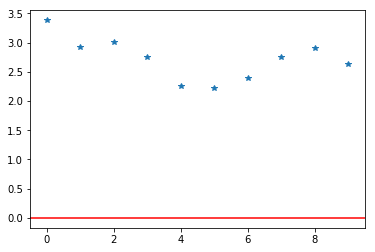

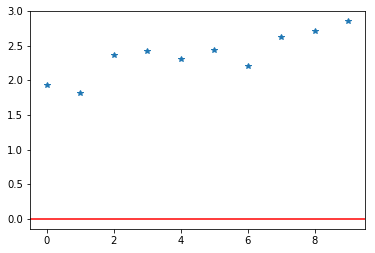

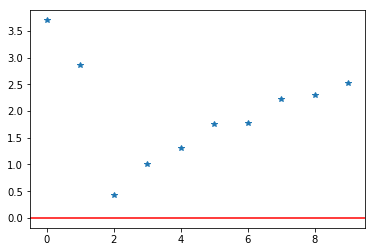

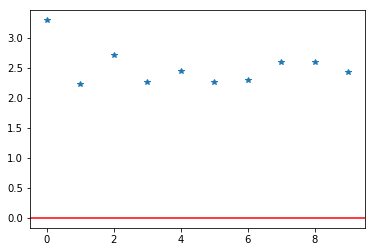

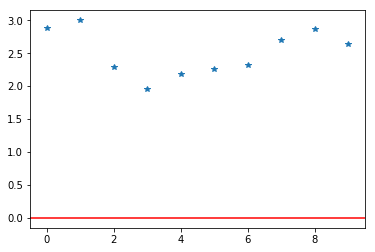

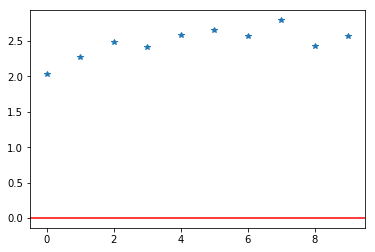

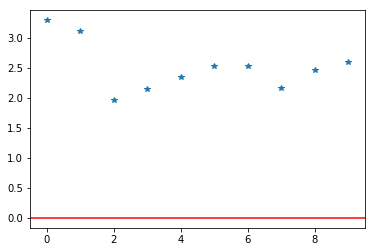

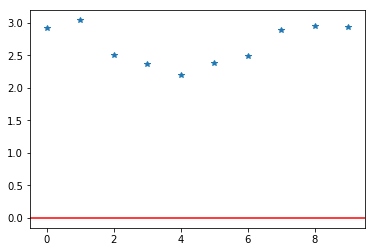

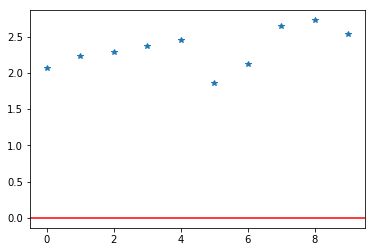

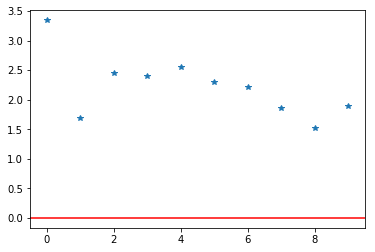

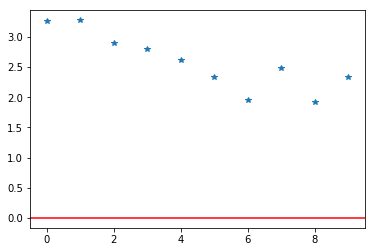

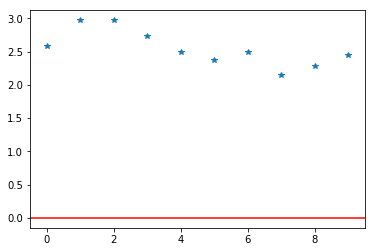

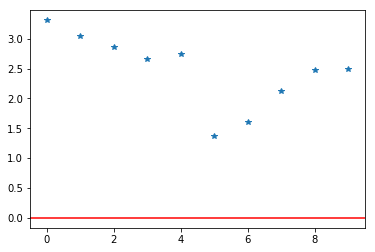

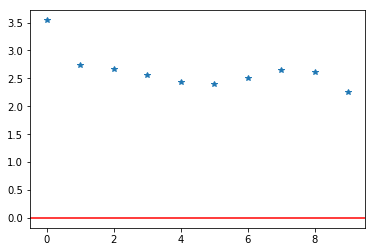

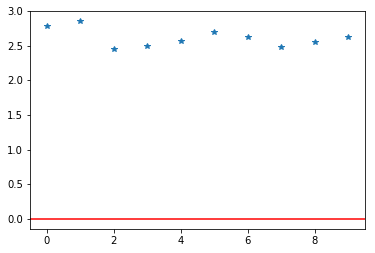

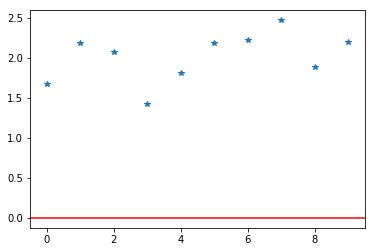

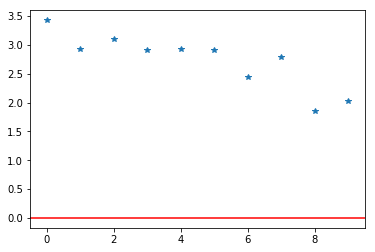

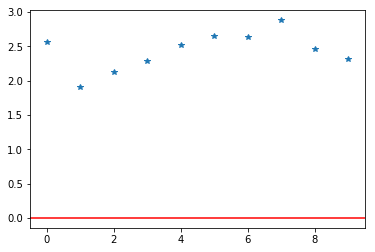

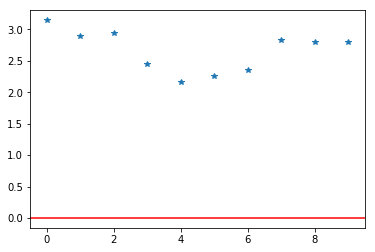

In [29]:
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [30]:
targets =  extract_anomaly_target(pd.DataFrame(data.reshape(40 * 10, 2)), 40, 1, 2, 10, 0.01)
smoothed_scores = detector.smoothed_sample_anomalies(scores)

100%|██████████| 10/10 [00:00<00:00, 73.64it/s]

Start probabilities memorization



/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=1,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])
/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


In [31]:
targets.shape

(400,)

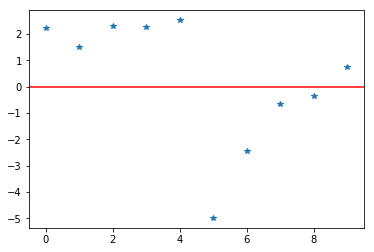

[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]


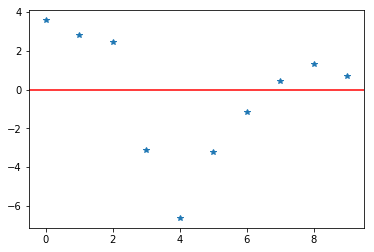

[ 0.  0.  1.  1.  1.  0.  0.  0.  0.  0.]


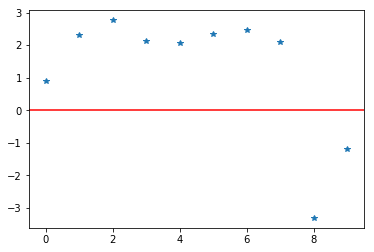

[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0.]


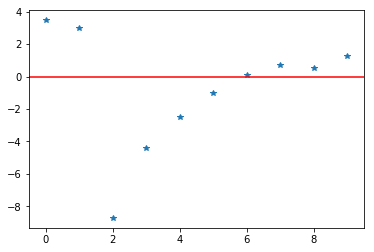

[ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]


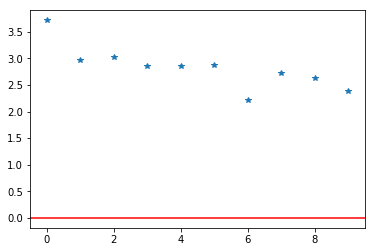

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


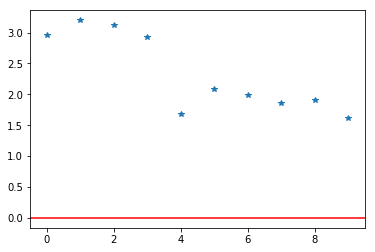

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


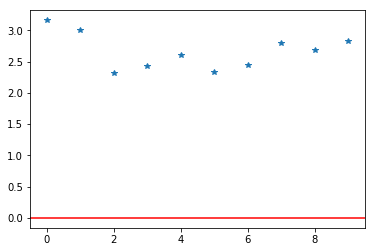

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


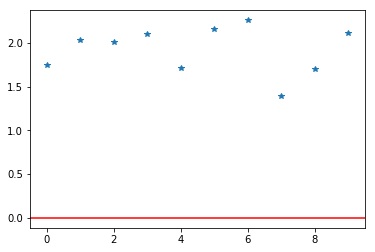

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


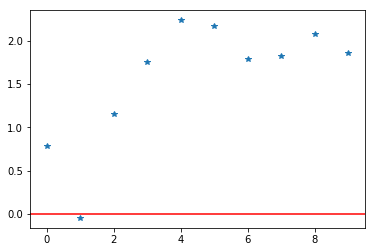

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


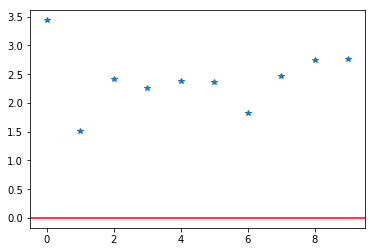

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


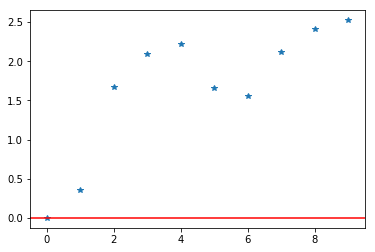

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


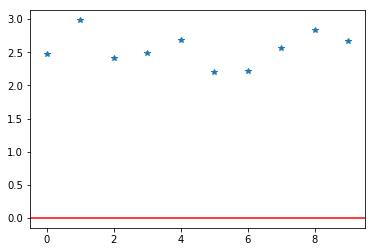

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


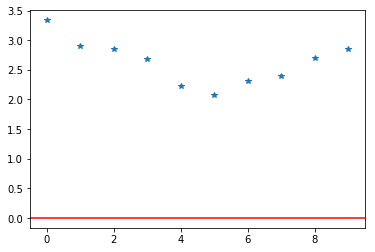

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


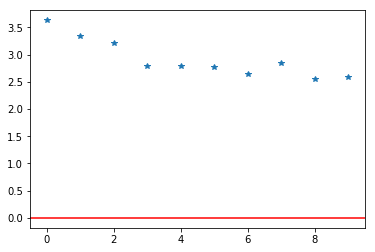

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


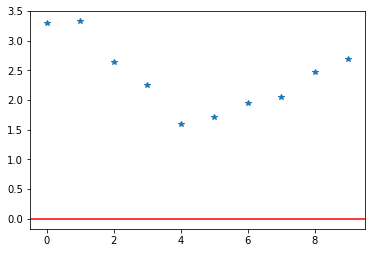

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


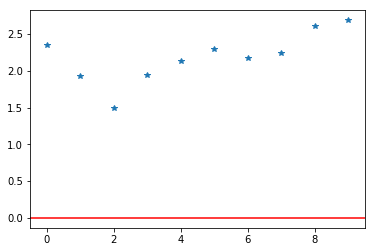

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


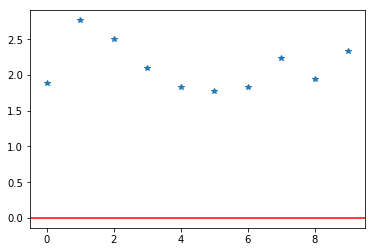

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


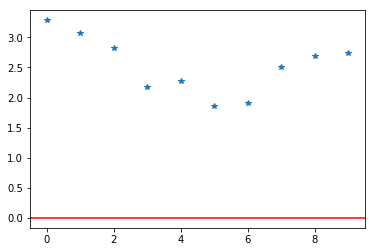

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


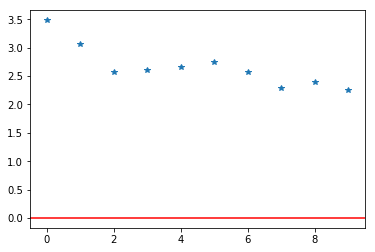

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


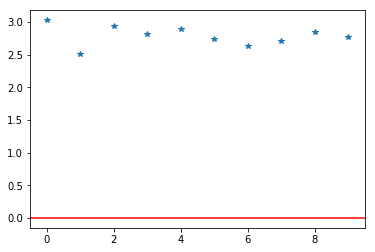

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


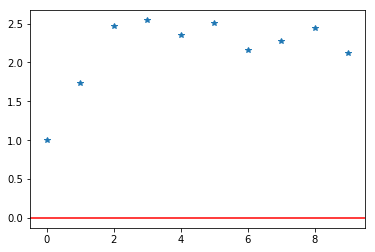

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


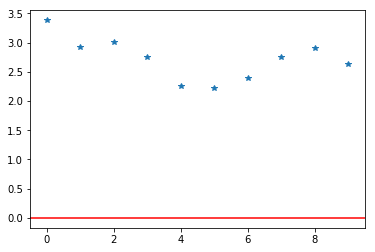

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


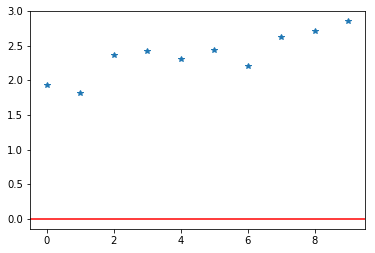

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


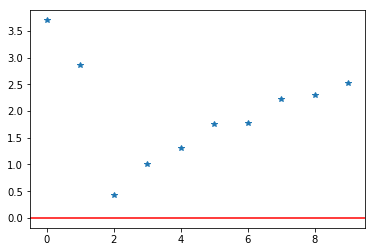

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


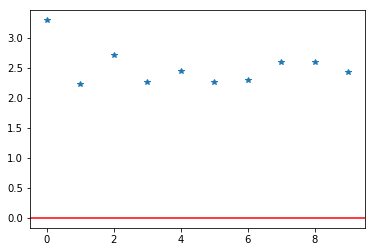

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


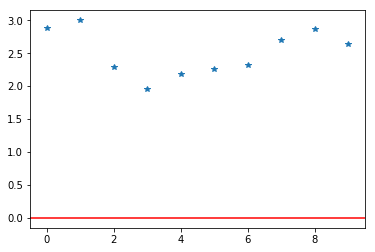

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


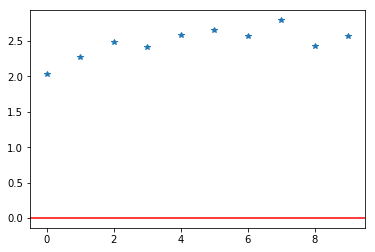

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


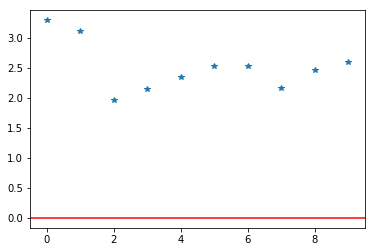

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


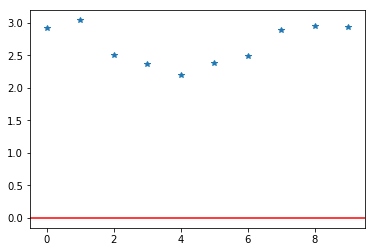

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


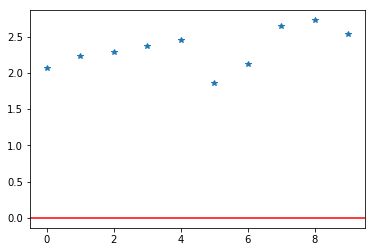

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


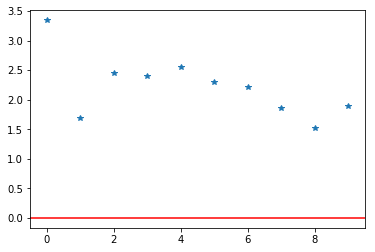

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


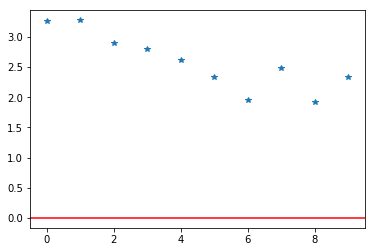

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


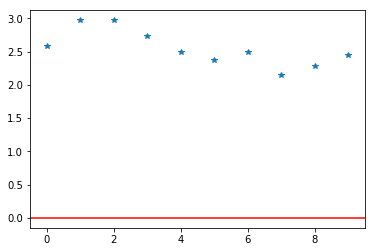

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


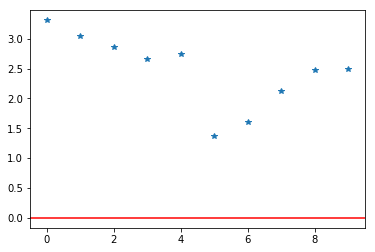

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


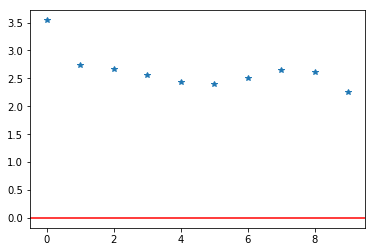

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


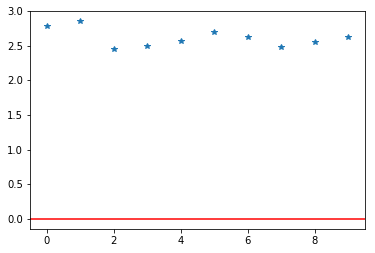

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


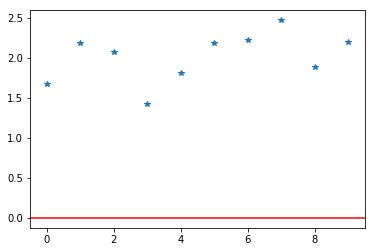

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


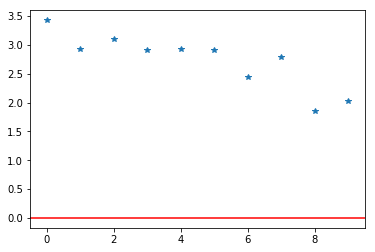

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


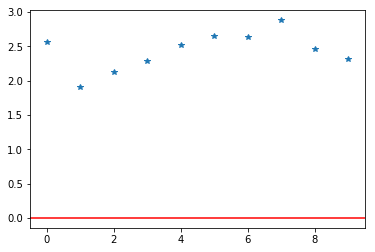

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


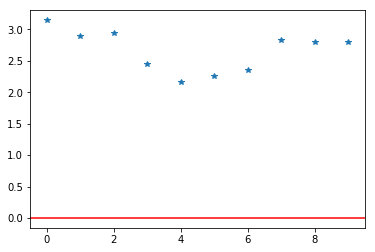

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [32]:
targets2d = targets.reshape((40,10))
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()
    print(targets2d[f])

### MNIST anomalies example

In [3]:
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print('X размера', X_train.shape, 'y размера', y_train.shape)

X размера (50000, 1, 28, 28) y размера (50000,)


In [4]:
X_train = X_train.reshape(-1, 28, 28)

In [5]:
X_train.shape

(50000, 28, 28)

In [223]:
X_train4 = np.array([x for i, x in enumerate(X_train) if y_train[i] == 4])

выберем небольшой сэмпл

In [224]:
inds = np.random.choice(np.arange(len(X_train4)), size=1000, replace=False)
X_sample = X_train4[inds]
# y_sample = y_train[inds]

будем считать как время вертикальную ось и искать аномалии вдоль горизонтальных линий изображений. То есть пространство для поиска аномалий бинарные вектора длины 28

Если взять больше 5 компонент то может не сойтись: произойдет деградация существующих кластеров и sklearn скажет об этом

In [225]:
%%time
detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=42,
                                                tol=1e-6)
scores = detector.fit(X_sample)

  1%|▏         | 14/1000 [00:00<00:07, 132.54it/s]

Start probabilities memorization


100%|██████████| 1000/1000 [00:07<00:00, 128.11it/s]


CPU times: user 16.1 s, sys: 1.74 s, total: 17.8 s
Wall time: 17.8 s


сгладим оценки правдоподобия вдоль линии времени экспоненциальным сглаживанием с окном 7 строк (1/4)  высоты изображения

In [226]:
smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife=7)

/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=7,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


посмотрим топ 50 аномалий 

In [234]:
top_anomaly = detector.find_anomalies(smoothed_scores, 
                                      strategy='series', anomaly_top=0.05)[0][:20]

In [263]:
num_anomaly = np.array(np.array(top_anomaly)[:, 1], dtype=int)

In [264]:
num_anomaly

array([819, 846, 896, 546, 897, 282, 943, 268, 955, 198, 764, 795, 865,
       634, 920, 383, 329, 391, 314, 229])

In [268]:
%%time
from sklearn.manifold import TSNE

tr = TSNE(n_iter=1500)
X_trans = tr.fit_transform(X_sample.reshape(-1, 28 * 28))

CPU times: user 35.2 s, sys: 3.68 s, total: 38.9 s
Wall time: 40.1 s


In [269]:
X_trans = np.array(X_trans)

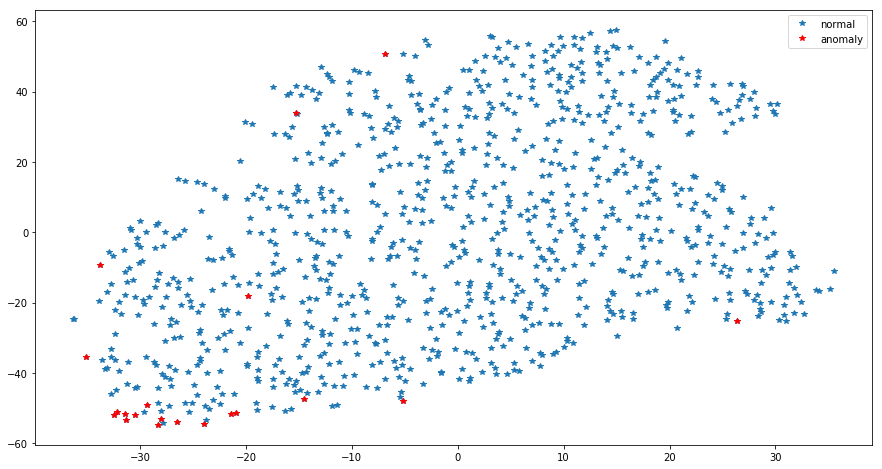

In [275]:
plt.figure(figsize=(15, 8))
plt.plot(X_trans[:, 0], X_trans[:, 1], '*', label='normal')
plt.plot(X_trans[num_anomaly, 0], X_trans[num_anomaly, 1], '*', color='r', label='anomaly')
plt.legend()
plt.show()

array([ 819.,  846.,  896.,  546.,  897.,  282.,  943.,  268.,  955.,
        198.,  764.,  795.,  865.,  634.,  920.,  383.,  329.,  391.,
        314.,  229.])

распределение правдоподобий:

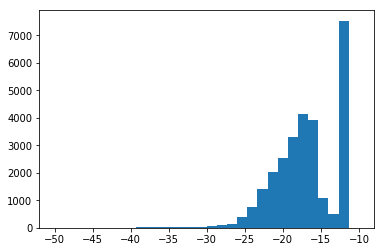

In [235]:
plt.hist(np.nan_to_num(scores.reshape(-1)), bins=30, range=(-50,-10))
plt.show()

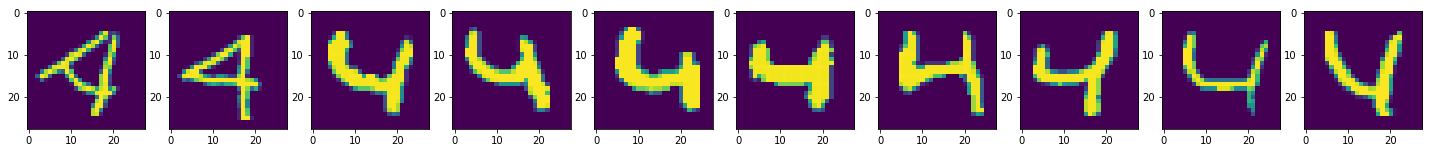

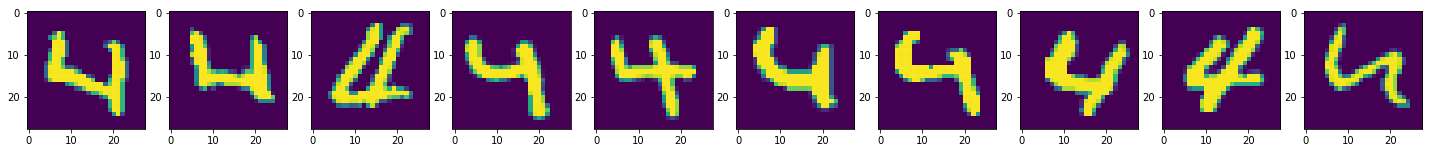

In [236]:
k=10
for i, item in enumerate(top_anomaly):
    if i % k == 0:
        plt.figure(figsize=(25, 10))
    num = item[1]
    score = item[0]
    plt.subplot(1, k, i % k + 1)
    plt.imshow(X_sample[num])
    if i % k == k - 1:
        plt.show()
#     print('index: {}, class: {}'.format(num, y_sample[num]))

In [218]:
all_anomaly = detector.find_anomalies(smoothed_scores, 
                                      strategy='series', anomaly_top=1)[0][-20:]

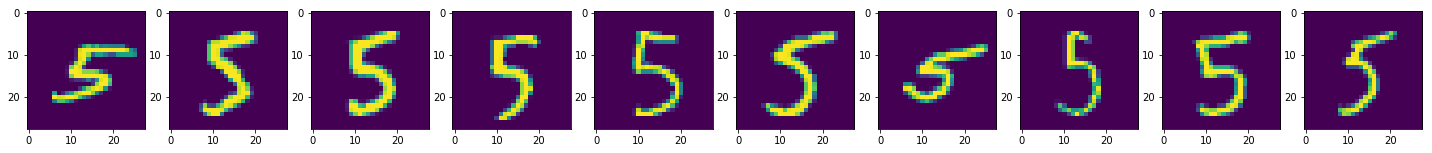

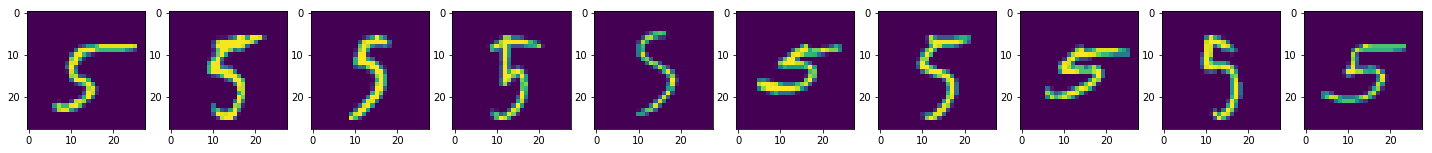

In [219]:
k=10
for i, item in enumerate(all_anomaly):
    if i % k == 0:
        plt.figure(figsize=(25, 10))
    num = item[1]
    score = item[0]
    plt.subplot(1, k, i % k + 1)
    plt.imshow(X_sample[num])
    if i % k == k - 1:
        plt.show()
#     print('index: {}, class: {}'.format(num, y_sample[num]))

полученные цифры действительно выглядят аномально: в основном из-за слишком длинных хвостов у цифр 2,5,6,7 или толщины обода 0. bad_line показывает номер горизонтальной аномальной линии из за которой изображение и было признано аномальным

можно взглянуть именно на те линии которые считаются наиболее аномальными

In [279]:
from skimage.color import gray2rgb
from collections import defaultdict

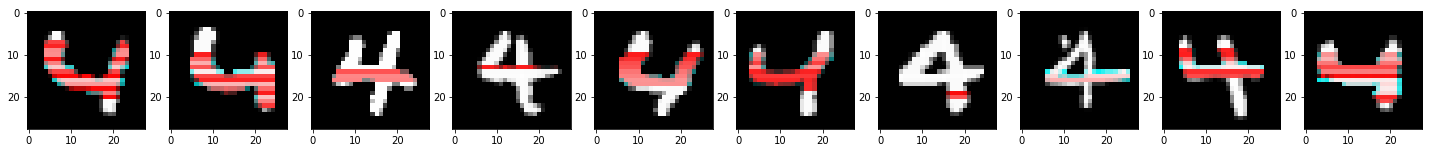

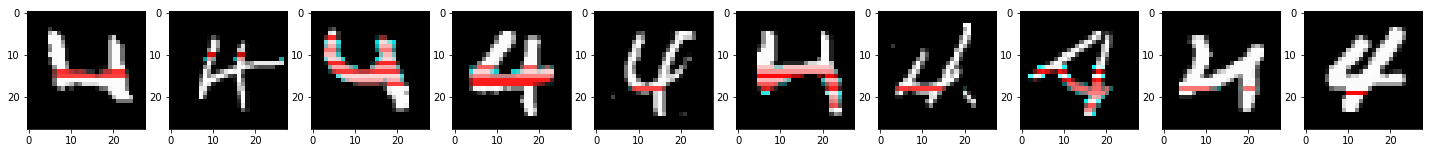

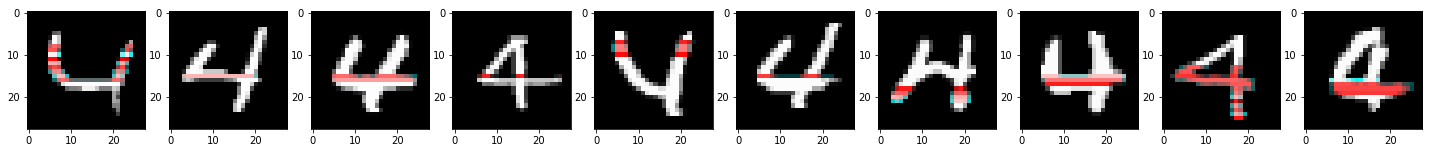

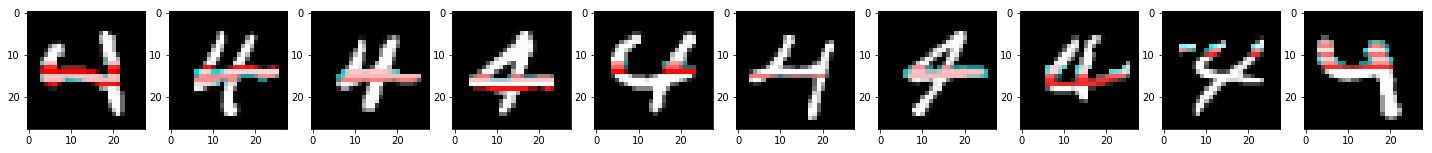

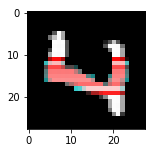

In [326]:
k=10
imgs = set()
lines = defaultdict(list)
for item in detector.find_anomalies(smoothed_scores, 
                                      strategy='sample', anomaly_top=0.05)[0]:
    
    num = item[1][0]
    line = item[1][1]
    score = item[0]
    lines[num].append((line, score))
    imgs.add(num)
    if len(imgs) > 40:
        break
        
for i, num in enumerate(imgs):
    img = gray2rgb(X_sample[num])
    if i % k == 0:
        plt.figure(figsize=(25, 10))
#     plt.subplot(1,2,1)
#     plt.imshow(img)
    for line,score in lines[num]:
        img[line-2][:, 1:3] = min(255, max(0, np.log(-score) * 20)) * (img[line-2][:, 1:3] > 0)
#         img[line-2][:, 0] /
#     plt.subplot(1,2,2)
#     plt.imshow(img)
#     plt.show()
    
    plt.subplot(1, k, i % k + 1)
    plt.imshow(img)
    if i % k == k - 1:
        plt.show()
#     print('index: {}, class: {}, bad_line: {}'.format(num, y_sample[num], line))

### NAB Traffic data example

In [120]:
frame2series = lambda df: pd.Series(df['value'], index=df.index)

travel = frame2series(pd.read_csv('realTraffic/TravelTime_387.csv', index_col='timestamp'))
speed = frame2series(pd.read_csv('realTraffic/speed_6005.csv', index_col='timestamp'))
occupancy = frame2series(pd.read_csv('realTraffic/occupancy_6005.csv', index_col='timestamp'))

 возьмем пересечение индексов(timestamp):

In [122]:
travel

timestamp
2015-07-10 14:24:00     564
2015-07-10 14:38:00     730
2015-07-10 14:48:00     770
2015-07-10 15:03:00     910
2015-07-10 15:22:00    1035
2015-07-10 15:32:00    1065
2015-07-10 15:42:00     953
2015-07-10 15:52:00    1005
2015-07-10 16:02:00     996
2015-07-10 16:12:00     901
2015-07-10 16:22:00     939
2015-07-10 16:32:00     988
2015-07-10 16:42:00    1020
2015-07-10 16:52:00     876
2015-07-10 17:02:00     870
2015-07-10 17:12:00     809
2015-07-10 17:22:00     884
2015-07-10 17:32:00     926
2015-07-10 17:42:00     829
2015-07-10 18:02:00     712
2015-07-10 18:12:00     624
2015-07-10 18:22:00     632
2015-07-10 18:32:00     596
2015-07-10 18:42:00     510
2015-07-10 18:52:00     526
2015-07-10 19:32:00      99
2015-07-10 19:42:00      85
2015-07-10 20:02:00      85
2015-07-10 20:12:00      87
2015-07-10 20:22:00      93
                       ... 
2015-09-17 12:31:00     127
2015-09-17 12:41:00     121
2015-09-17 12:51:00     131
2015-09-17 13:01:00     129
2015-09-17

In [111]:
for day in np.unq

In [112]:
travel_aggr

timestamp  timestamp  timestamp  timestamp
7          10         14         24            564
                                 38            730
                                 48            770
                      15         3             910
                                 22           1035
                                 32           1065
                                 42            953
                                 52           1005
                      16         2             996
                                 12            901
                                 22            939
                                 32            988
                                 42           1020
                                 52            876
                      17         2             870
                                 12            809
                                 22            884
                                 32            926
                                 42    